In [38]:
# Load all telemetry CSV parts in all monthly subdirectories
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

data_dir = Path(".")
csv_parts = sorted(data_dir.rglob("part-0000*-c000.csv"))
if not csv_parts:
    raise FileNotFoundError(
        f"No telemetry CSV parts found when searching under {data_dir.resolve()}."
    )

df = pd.concat(
    (pd.read_csv(path).assign(source_file=path.name) for path in csv_parts),
    ignore_index=True,
)
# limit to a specific time range
start = pd.Timestamp("2025-10-08 14:00", tz="UTC")
end = pd.Timestamp("2025-11-20 22:00", tz="UTC")


In [39]:
# Summarize samples per signal name
signal_summary = (
    df.groupby("signaldata_signalname")
    .agg(
        sample_count=("signaldata_signalname", "size"),
        earliest_occurrence=("signaldata_timeofoccurrence", "min"),
        latest_occurrence=("signaldata_timeofoccurrence", "max"),
    )
    .reset_index()
    .sort_values("sample_count", ascending=False)
 )
signal_summary.head(20)

,signaldata_signalname,sample_count,earliest_occurrence,latest_occurrence
4,BMS_IstSpannung,520871,1757751101245,1763486417744
5,BMS_IstStrom_02,520861,1757751101245,1763486417744
50,KL_IstLeistung,130492,1757751101982,1763486417681
37,HVLB_IstStrom_HVHS,130332,1757751101736,1763486417672
36,HVLB_IstSpannung_HVHS,130330,1757751101736,1763486417672
27,BMS_Temperatur,130252,1757751101887,1763486417816
12,BMS_IstVorlaufTemperatur,130227,1757751101887,1763486417816
26,BMS_SollVorlauftemperatur,130226,1757751101887,1763486417816
41,HVLM_Ladeart,130216,1757751101962,1763486416996
0,BMS_Energieinhalt_HiRes,130192,1757751101986,1763486417915


In [40]:
# Count rows contributed by each CSV part for debugging
rows_per_file = (
    df.groupby("source_file")
    .size()
    .reset_index(name="row_count")
    .sort_values("row_count", ascending=False)
 )
# rows_per_file

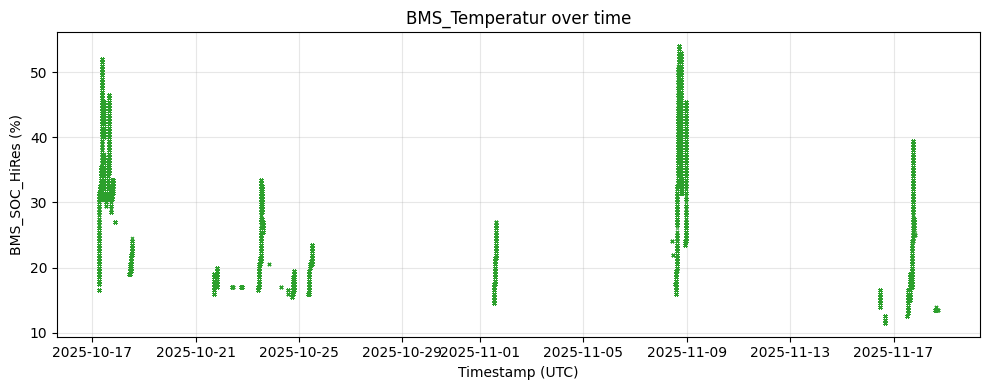

In [41]:
# soc over time plot
signal_name = "BMS_Temperatur"

signal_df = df.loc[df["signaldata_signalname"] == signal_name].copy()
if signal_df.empty:
    raise ValueError(f"Signal '{signal_name}' not found in the dataframe.")

signal_df["timestamp"] = pd.to_datetime(
    signal_df["signaldata_timeofoccurrence"],
    unit="ms",
    errors="coerce",
    utc=True,
)
signal_df = signal_df.dropna(subset=["timestamp"]).sort_values("timestamp")
signal_df = signal_df[(signal_df["timestamp"] >= start) & (signal_df["timestamp"] < end)]

plt.figure(figsize=(10, 4))
plt.plot(
    signal_df["timestamp"],
    signal_df["signaldata_interpretedvalue_asdoublevalue"],
    marker='x', linestyle='', markersize=2, alpha=0.7,
    color="tab:green",
)
plt.title(f"{signal_name} over time")
plt.xlabel("Timestamp (UTC)")
plt.ylabel("BMS_SOC_HiRes (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [42]:
# signaldata_interpretedvalue_asdoublevalue 
signal_df.signaldata_interpretedvalue_asdoublevalue.describe()


count    117502.000000
mean         28.194184
std           9.734230
min          11.500000
25%          19.500000
50%          30.000000
75%          34.500000
max          54.000000
Name: signaldata_interpretedvalue_asdoublevalue, dtype: float64

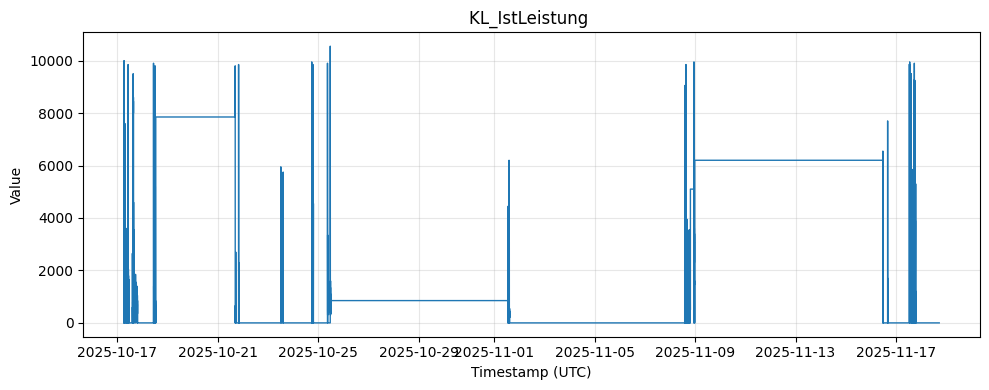

In [43]:
# Plot KL_IstLeistung over time 

signal_name = "KL_IstLeistung"
signal_df = df.loc[df["signaldata_signalname"] == signal_name].copy()
if signal_df.empty:
    raise ValueError(f"Signal '{signal_name}' not found in the dataframe.")

signal_df["timestamp"] = pd.to_datetime(
    signal_df["signaldata_timeofoccurrence"],
    unit="ms",
    errors="coerce",
    utc=True
)
signal_df = signal_df.dropna(subset=["timestamp"]).sort_values("timestamp")


signal_df = signal_df[(signal_df["timestamp"] >= start) & (signal_df["timestamp"] < end)]

plt.figure(figsize=(10, 4))
plt.step(signal_df["timestamp"], signal_df["signaldata_interpretedvalue_asdoublevalue"], linewidth=1)
plt.title("KL_IstLeistung ")
plt.xlabel("Timestamp (UTC)")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()

<Axes: title={'center': 'calc_IstLeistung (kW)'}, xlabel='signaldata_timeofoccurrence', ylabel='signaldata_interpretedvalue_asdoublevalue'>

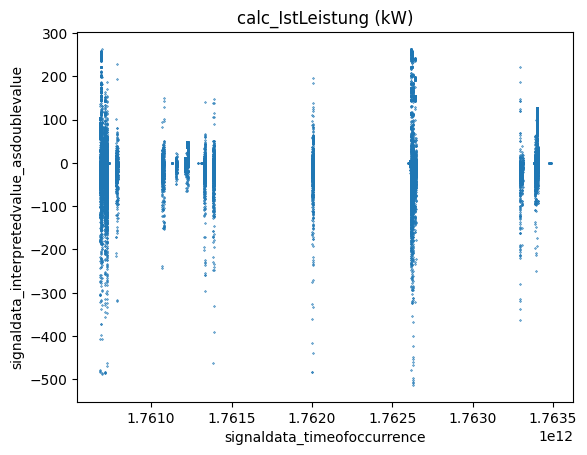

In [44]:
# Create calc_IstLeistung (kW) from voltage and current signals
voltage_signal = "BMS_IstSpannung"
current_signal = "BMS_IstStrom_02"
target_signal = "calc_IstLeistung"
value_col = "signaldata_interpretedvalue_asdoublevalue"
join_cols = ["source_file", "signaldata_timeofoccurrence"]


df = df[
    (pd.to_datetime(df["signaldata_timeofoccurrence"], unit="ms", utc=True) >= start) &
    (pd.to_datetime(df["signaldata_timeofoccurrence"], unit="ms", utc=True) < end)
].copy()

df_columns = df.columns
missing_signals = [s for s in (voltage_signal, current_signal) if s not in df["signaldata_signalname"].unique()]
if missing_signals:
    raise ValueError(f"Missing required signals for power calculation: {missing_signals}")

missing_join_cols = [c for c in join_cols if c not in df.columns]
if missing_join_cols:
    raise ValueError(f"Required columns for alignment not found: {missing_join_cols}")

# Use voltage rows as the metadata backbone and align current samples via timestamp + file
voltage_df = df.loc[df["signaldata_signalname"] == voltage_signal].copy()
voltage_df = voltage_df.rename(columns={value_col: "voltage_value"})
current_df = (
    df.loc[df["signaldata_signalname"] == current_signal, join_cols + [value_col]]
    .rename(columns={value_col: "current_value"})
)

aligned = pd.merge(voltage_df, current_df, on=join_cols, how="inner")
if aligned.empty:
    raise ValueError(
        "No overlapping voltage/current samples found when aligning on "
        f"columns {join_cols}."
    )

calc_df = aligned.copy()
calc_df["signaldata_signalname"] = target_signal
calc_df[value_col] = (calc_df["voltage_value"] * calc_df["current_value"]) / 1000.0
calc_df = calc_df.loc[:, df_columns]

# Drop any prior derived samples before appending the new kW signal
df = df.loc[df["signaldata_signalname"] != target_signal]
df = pd.concat([df, calc_df], ignore_index=True)

calc_df.plot(
    x="signaldata_timeofoccurrence",
    kind="scatter",
    y=value_col,
    title="calc_IstLeistung (kW)",
    s=1,
    marker='x',
    alpha=0.6,
)

Text(0, 0.5, 'Sample count')

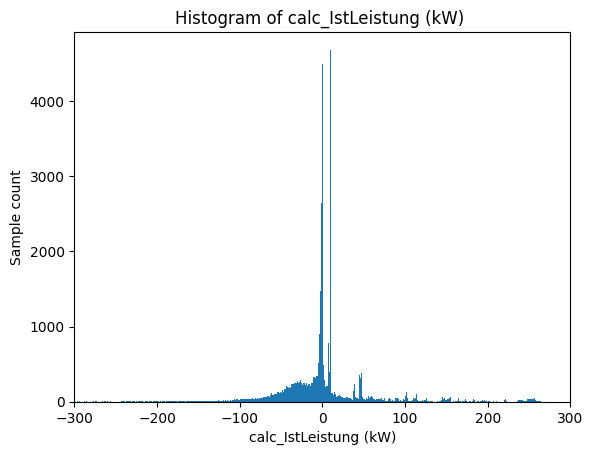

In [45]:

# Histogram of calc_df limited to the desired x-axis range
x_axis_start = -300
x_axis_stop = 300
bin_width = 1

if x_axis_start >= x_axis_stop:
    raise ValueError("x_axis_start must be less than x_axis_stop for histogram range.")

hist_bins = np.arange(x_axis_start, x_axis_stop + bin_width, bin_width)
data_slice = calc_df.loc[
    calc_df[value_col].between(x_axis_start, x_axis_stop, inclusive="both"),
    value_col,
]
if data_slice.empty:
    raise ValueError("No calc_IstLeistung samples fall within the specified x-axis range.")

ax = data_slice.plot(
    kind="hist",
    bins=hist_bins,
    title="Histogram of calc_IstLeistung (kW) ",
)
ax.set_xlim(x_axis_start, x_axis_stop)
ax.set_xlabel("calc_IstLeistung (kW)")
ax.set_ylabel("Sample count")

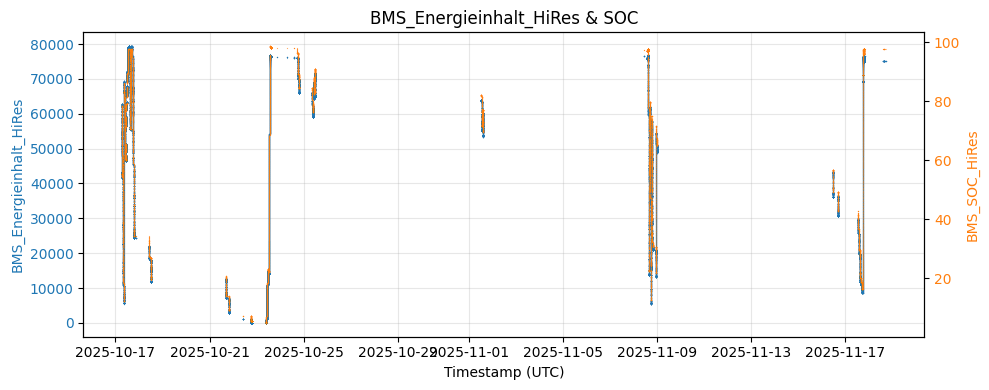

In [56]:
# BMS_Energieinhalt_HiRes over time plot with BMS_SOC_HiRes secondary axis
signal_name = "BMS_Energieinhalt_HiRes"
signal_name2 = "BMS_SOC_HiRes"
value_col = "signaldata_interpretedvalue_asdoublevalue"

signal_df = df.loc[df["signaldata_signalname"] == signal_name].copy()
if signal_df.empty:
    raise ValueError(f"Signal '{signal_name}' not found in the filtered dataframe.")

signal_df["timestamp"] = pd.to_datetime(
    signal_df["signaldata_timeofoccurrence"],
    unit="ms",
    errors="coerce",
    utc=True,
)
signal_df = signal_df.dropna(subset=["timestamp"]).sort_values("timestamp")

soc_df = df.loc[df["signaldata_signalname"] == signal_name2, ["signaldata_timeofoccurrence", value_col]].copy()
if soc_df.empty:
    raise ValueError(f"Signal '{signal_name2}' not found in the filtered dataframe.")

soc_df["timestamp"] = pd.to_datetime(
    soc_df["signaldata_timeofoccurrence"],
    unit="ms",
    errors="coerce",
    utc=True,
)
soc_df = soc_df.dropna(subset=["timestamp"]).sort_values("timestamp")

fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(signal_df["timestamp"], signal_df[value_col], marker='x', linestyle='', markersize=0.2, alpha=0.6, color="tab:blue")
ax1.set_title("BMS_Energieinhalt_HiRes & SOC")
ax1.set_xlabel("Timestamp (UTC)")
ax1.set_ylabel("BMS_Energieinhalt_HiRes", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(soc_df["timestamp"], soc_df[value_col], marker='x', linestyle='', markersize=0.2, alpha=0.4, color="tab:orange")
ax2.set_ylabel("BMS_SOC_HiRes", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

fig.tight_layout()

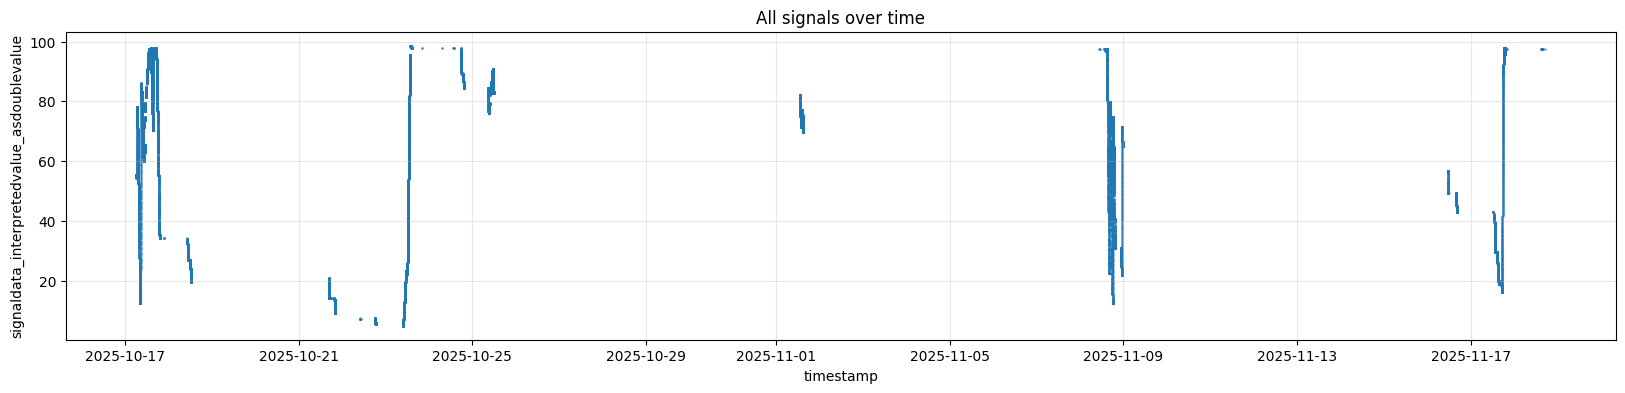

In [47]:
signal_of_interest = "BMS_SOC_HiRes"


time_col = "signaldata_timeofoccurrence"
timestamps = pd.to_datetime(df[time_col], unit="ms", utc=True)

mask = (timestamps >= start) & (timestamps < end)

my_df = df.loc[mask & (df["signaldata_signalname"] == signal_of_interest)].copy()

my_df = my_df.loc[mask].copy()
my_df["timestamp"] = timestamps.loc[mask]

fig, ax = plt.subplots(figsize=(20, 4))
my_df.plot(
    x="timestamp",
    kind="scatter",
    y="signaldata_interpretedvalue_asdoublevalue",
    title="All signals over time",
    s=0.5,
    alpha=0.6,
    ax=ax,
)
ax.grid(True, alpha=0.3)

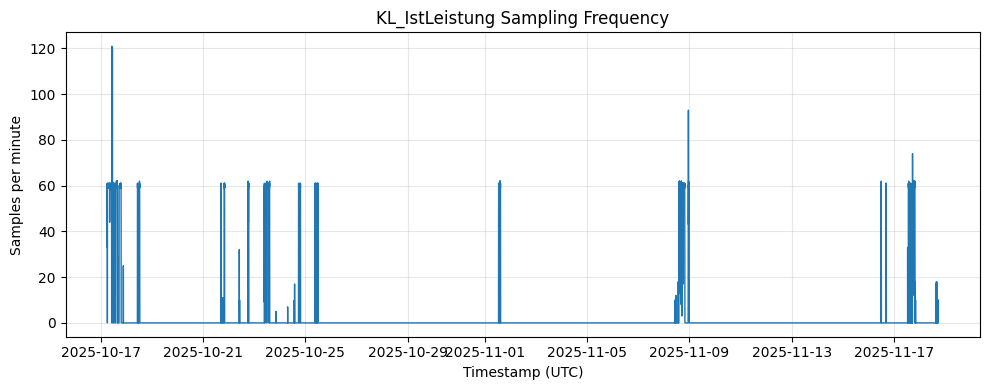

In [48]:
# Plot sampling frequency of KL_IstLeistung over time (15-minute bins)
signal_name = "KL_IstLeistung"
signal_df = df.loc[df["signaldata_signalname"] == signal_name].copy()
if signal_df.empty:
    raise ValueError(f"Signal '{signal_name}' not found in the dataframe.")

signal_df["timestamp"] = pd.to_datetime(
    signal_df["signaldata_timeofoccurrence"],
    unit="ms",
    errors="coerce",
    utc=True
)
signal_df = signal_df.dropna(subset=["timestamp"]).set_index("timestamp").sort_index()
signal_df = signal_df[(signal_df.index >= start) & (signal_df.index < end)]

freq = signal_df.resample("1min").size().rename("samples_per_15min")
if freq.empty:
    raise ValueError("No data available to plot sampling frequency.")

plt.figure(figsize=(10, 4))
plt.plot(freq.index, freq.values, linewidth=1)
plt.title("KL_IstLeistung Sampling Frequency")
plt.xlabel("Timestamp (UTC)")
plt.ylabel("Samples per minute")
plt.grid(True, alpha=0.3)
plt.tight_layout()